In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json


In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Importing required libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification

#### Loading data

In [4]:
data = pd.read_json("/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json", lines=True)
df = data[['headline', 'short_description', 'category']].dropna()
df.head()

,headline,short_description,category
0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...,U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha...",COMEDY
3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to...",PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,U.S. NEWS


In [5]:
# Checking for null values
print(df.isnull().sum())

headline             0
short_description    0
category             0
dtype: int64


#### Plotting

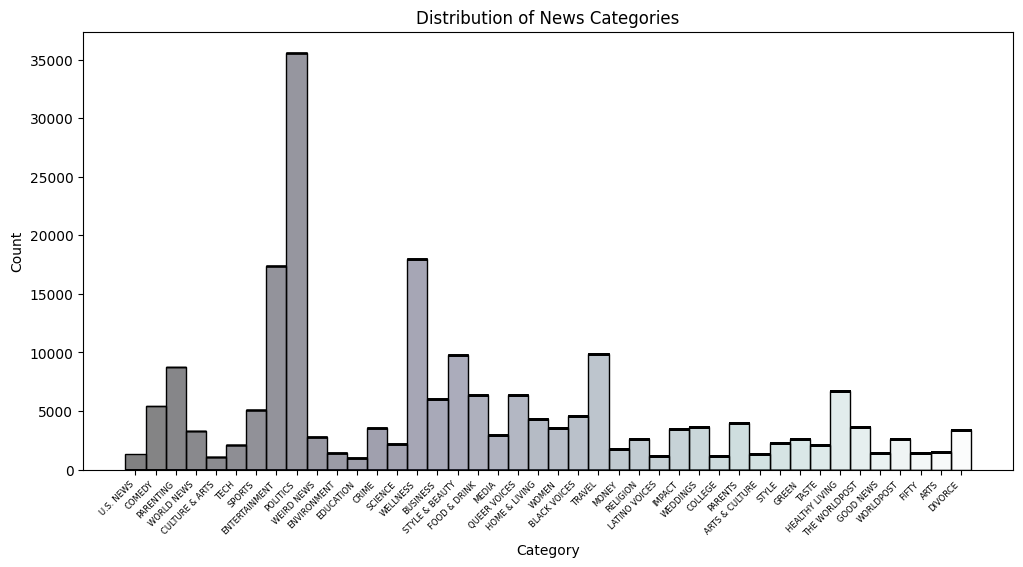

In [6]:
# Histogram of each category
plt.figure(figsize=(12, 6))
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
sns.histplot(
    data=df,
    x="category",
    palette="bone",
    hue="category",
    multiple="stack",
    kde=True,
)
plt.title("Distribution of News Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.legend().remove()
plt.xticks(rotation=45, fontsize=6, ha='right')
plt.show()

#### Encoding the labels

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])
df.head()

,headline,short_description,category,label
0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...,U.S. NEWS,35
1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...,U.S. NEWS,35
2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha...",COMEDY,5
3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to...",PARENTING,22
4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,U.S. NEWS,35


#### Train Test Split

In [8]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.1, random_state=1, stratify=df['label'])
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=1, stratify=val_df['label'])

#### Tokenization

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
max_length = 128

def tokenize_texts(texts):
    return tokenizer(
        list(texts),
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

train_encodings = tokenize_texts(train_df['headline'])
val_encodings = tokenize_texts(val_df['headline'])
test_encodings = tokenize_texts(test_df['headline'])

#### Preparing the datasets

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_df['label'].values
)).shuffle(1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_df['label'].values
)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_df['label'].values
)).batch(32)

#### Loading the model

In [ ]:
num_labels = df['label'].nunique()
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

#### Compiling

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [13]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  32298     
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66985770 (255.53 MB)
Trainable params: 66985770 (255.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Early stopping

In [14]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

#### Fitting 

In [15]:
model_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=[early_stopping]
)

Epoch 1/3


I0000 00:00:1751519988.172500      71 service.cc:148] XLA service 0x7d59b0003ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751519988.173805      71 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751519988.173828      71 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751519988.302189      71 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751519988.482467      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5893/5893 [==============================] - 2461s 413ms/step - loss: 1.5446 - accuracy: 0.5788 - val_loss: 1.2374 - val_accuracy: 0.6416
Epoch 2/3
5893/5893 [==============================] - 2438s 414ms/step - loss: 1.1250 - accuracy: 0.6689 - val_loss: 1.1980 - val_accuracy: 0.6504
Epoch 3/3
5893/5893 [==============================] - 2437s 414ms/step - loss: 0.9131 - accuracy: 0.7256 - val_loss: 1.2416 - val_accuracy: 0.6524


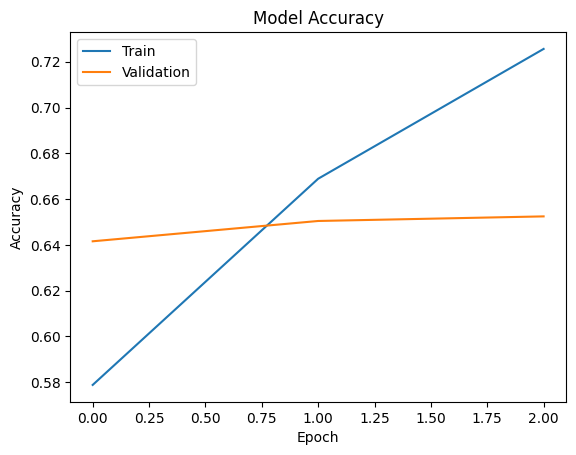

In [16]:
# Accuracy history summary
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

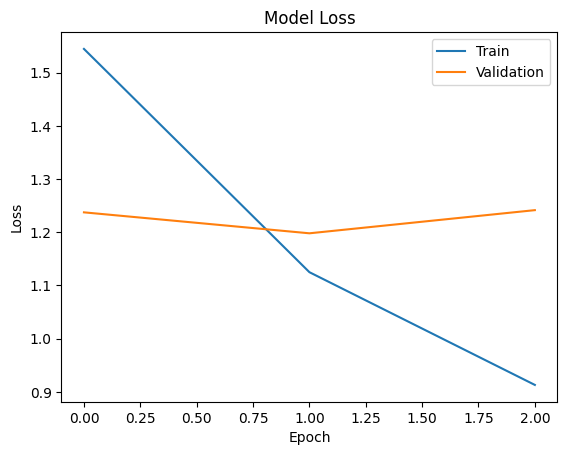

In [17]:
# Loss history summary
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

#### Metrics

In [18]:
validation_accuracy = model.evaluate(val_dataset)
test_accuracy = model.evaluate(test_dataset)

print(f"validation accuracy : {validation_accuracy[1]:0.4f}")
print(f"test accuracy : {test_accuracy[1]:0.4f}")

328/328 [==============================] - 49s 150ms/step - loss: 1.2453 - accuracy: 0.6529
validation accuracy : 0.6524
test accuracy : 0.6529


#### Saving the model

In [19]:
import joblib
model.save_pretrained('/kaggle/working/classifier')
tokenizer.save_pretrained('/kaggle/working/classifier')
joblib.dump(label_encoder, 'encoder.pkl')

['encoder.pkl']